# Quantum-Ready MRI Preprocessing:  
## Converting 4-Class Alzheimer Brain Scans to Theta-Encoded Feature Vectors

> **Dataset:** 6,400 MRI images (4 classes)  
> **Task:** Binary classification (Non-Demented vs Demented)  
> **Encoding:** Pixel intensity → θ ∈ [0, π/2] for quantum state preparation  
> **Output:** Four `.npy` files in `processed/` folder

## 1. Imports & Google-Drive mount

In [9]:
import os, glob, numpy as np, matplotlib.pyplot as plt, cv2
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split

# --- Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Root folder ---
ROOT = "/content/drive/MyDrive/Colab Notebooks/Alzheimer_MRI_4_classes_dataset"
assert os.path.isdir(ROOT), f"Folder not found: {ROOT}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset lives on Google-Drive – mounting makes it accessible as /content/drive.
ROOT must contain the four class sub-folders (MildDemented/ … VeryMildDemented/).

##2. The preprocessing pipeline - load_transform

In [10]:
# --- load_transform function (exactly as you wrote) ---
def load_transform(filepath,
                   img_size=(16,16),          # final output size
                   conv_to_theta=True,        # 0-255 → 0-π/2
                   contrast=1,                # contrast multiplier
                   equalize=True,             # masked histogram equalisation
                   crop=True,                 # centre 1/3 crop
                   flatten=True):             # return 1-D vector
    img = Image.open(filepath).resize((128,128))
    img = np.array(img)

    # ---- centre crop (1/3 of the original side) ----
    if crop:
        loc = img.shape[0] // 3
        img = img[loc:loc*2, loc:loc*2 ]

    # ---- masked histogram equalisation (keeps dark background) ----
    if equalize:
        _, mask = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
        masked_eq = cv2.equalizeHist(img * (mask // 255))
        img = cv2.addWeighted(img, 0.5, masked_eq, 0.5, 0)

    # ---- final resize & optional contrast boost ----
    img = Image.fromarray(img).resize(img_size)
    if contrast != 1:
        img = ImageEnhance.Contrast(img).enhance(contrast)

    # ---- normalise to [0,1] then optionally to radians ----
    img = np.array(img) / 255.0
    if conv_to_theta:
        img = img * np.pi / 2.0

    # ---- flatten for quantum circuits (or keep 2-D) ----
    if flatten:
        img = img.flatten()
    return img

##3. Gather every image file & build label vectors

In [11]:
# --- Collect files ---
class_names = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
label_map = {n:i for i,n in enumerate(class_names)}

all_files, all_labels = [], []
for cls in class_names:
    files = glob.glob(os.path.join(ROOT, cls, "*.jpg"))
    all_files.extend(files)
    all_labels.extend([label_map[cls]] * len(files))

print(f"Total: {len(all_files)} images →",
      {cls: all_labels.count(i) for cls,i in label_map.items()})

Total: 6400 images → {'MildDemented': 896, 'ModerateDemented': 64, 'NonDemented': 3200, 'VeryMildDemented': 2240}


glob walks the four class folders and builds two parallel Python lists.
The label_map gives us integer IDs (0-3) – later we collapse them into a binary problem.

##4. Train / test split + full preprocessing

In [12]:
# --- Train-test split ---
train_files, test_files, train_y, test_y = train_test_split(
    all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# --- Process ---
def process(file_list):
    return np.stack([load_transform(f) for f in file_list])

print("Processing...")
train_X = process(train_files)
test_X  = process(test_files)

Processing...


train_test_split respects class proportions (stratify).
The tiny helper process() runs load_transform on every file and stacks the results into a NumPy matrix of shape (N, 16×16) (flattened → N, 256).

##5. Binary (Non-Demented vs Demented) split & save

In [13]:
print("Binary split")
# --- Binary split ---
non_label = label_map["NonDemented"]
dem_labels = [label_map["MildDemented"], label_map["ModerateDemented"], label_map["VeryMildDemented"]]

train_0 = train_X[np.array(train_y) == non_label]      # Non-Demented
train_1 = train_X[np.isin(train_y, dem_labels)]       # All dementia classes
test_0  = test_X[np.array(test_y) == non_label]
test_1  = test_X[np.isin(test_y, dem_labels)]

print("saving")
# --- Save ---
os.makedirs("processed", exist_ok=True)
np.save("processed/train_0.npy", train_0)
np.save("processed/train_1.npy", train_1)
np.save("processed/test_0.npy",  test_0)
np.save("processed/test_1.npy",  test_1)
print("Saved: train_0.npy, train_1.npy, test_0.npy, test_1.npy")

Binary split
saving
Saved: train_0.npy, train_1.npy, test_0.npy, test_1.npy


We collapse the 4-class problem into a binary one because most quantum image classifiers work with two classes.
Four .npy files are written to a new folder processed/ – these are exactly what Quantum_Image_Classification.ipynb will load.

##6. Quick sanity-check visualisation

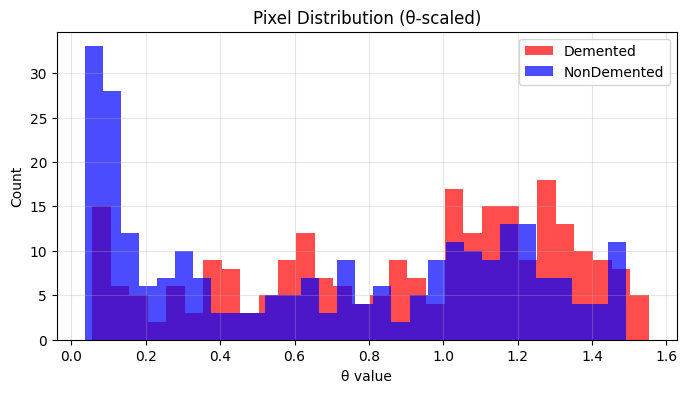

In [14]:
# --- Quick plot ---
plt.figure(figsize=(8,4))
plt.hist(test_1[0].flatten(), bins=30, alpha=0.7, label="Demented", color='red')
plt.hist(test_0[0].flatten(), bins=30, alpha=0.7, label="NonDemented", color='blue')
plt.title("Pixel Distribution (θ-scaled)")
plt.xlabel("θ value"); plt.ylabel("Count"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

Shows the θ-angle histogram of one random image from each binary class.
If the two distributions are clearly separated → the quantum encoder will have an easier job.